<a href="https://colab.research.google.com/github/joaopamaral/pytorch_challenge/blob/master/Image%20Classifier%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/joaopamaral/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [4]:
%matplotlib inline
import PIL
from PIL import Image

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Download Pytorch - Google Colab - http://pytorch.org/
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
    pytorch_version = '0.4.1'
    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-{pytorch_version}-{platform}-linux_x86_64.whl torchvision
        
    # Check PIL Version (Bug Google Colab)
    print('PIL.PILLOW_VERSION', PIL.PILLOW_VERSION)
    # workaround 
    if PIL.PILLOW_VERSION != '5.3.0':
        !pip install Pillow==5.3.0
        print('Restart Runtime before run the notebook!')
        
    from google.colab import drive
    drive.mount('/content/gdrive')
    
# Imports here
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models, datasets
from tqdm import tqdm

PIL.PILLOW_VERSION 5.3.0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')

CUDA is available!


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# download the dataset
!wget -q -nc https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!wget -q -nc https://raw.githubusercontent.com/joaopamaral/pytorch_challenge/master/cat_to_name.json
!unzip -q -o flower_data.zip

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train/'
valid_dir = data_dir + '/valid/'

In [0]:
mean = np.array((0.485, 0.456, 0.406))
std = np.array((0.229, 0.224, 0.225))

# Define transforms for the training and validation sets
training_transform = transforms.Compose([transforms.ColorJitter(hue=.05, saturation=.05),
#                                          transforms.RandomAffine(30, scale=(.5, 1)),
                                         transforms.Resize(224),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.CenterCrop(224), 
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean, std)])

validation_transform = transforms.Compose([transforms.Resize(224),
                                           transforms.CenterCrop(224), 
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean, std)])

# Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform=training_transform)
validation_datasets = datasets.ImageFolder(valid_dir, transform=validation_transform)

# Using the image datasets and the trainforms, define the dataloaders
# number of subprocesses to use for data loading
num_workers = 8
# how many samples per batch to load
batch_size = 64

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_datasets, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

print(len(cat_to_name))
print(cat_to_name['1'])

102
pink primrose


### Visualize some sample data

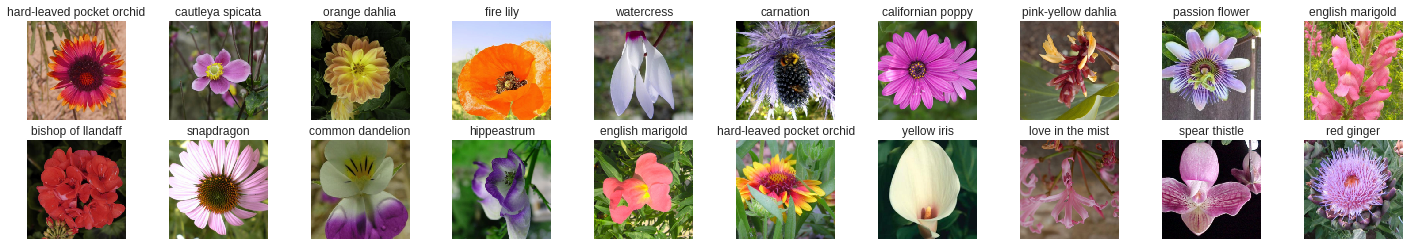

In [10]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = ((np.transpose(images[idx], (1, 2, 0)) * std) + mean).clip(min=0)
    plt.imshow(image)
    ax.set_title(cat_to_name[str(labels[idx].item())])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
# Build and train your network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
# print(model)

In [0]:
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 500),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(500, len(cat_to_name)),
                         nn.LogSoftmax(dim=1))

model.to(device);

criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=.9)

In [0]:
def training_step(model, epoch=0):
    model.train()
    
    train_loss = 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Training Model, Epoch {epoch}')):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    
    return train_loss

In [0]:
def validation_step(model, epoch=0, criterion=None):
    model.eval()
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    correct_validation = 0.0
    total_analised = 0.0
    valid_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(tqdm(validation_loader, desc=f'Validating Model, Epoch {epoch}')):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate accuracy
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        correct_validation += correct.sum()
        total_analised += correct.size
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    valid_loss = valid_loss/len(validation_loader.dataset)
    accuaracy_validation = correct_validation / len(validation_loader.dataset)
    
    return valid_loss, accuaracy_validation

In [15]:
valid_loss_min = np.Inf # track change in validation loss

# load model checkpoint
if IN_COLAB:
    model.load_state_dict(torch.load('gdrive/My Drive/pytorch_challenge_models/model_augmented_resnet_152_5.pt'))
    valid_loss, accuaracy_validation = validation_step(model)
    valid_loss_min = valid_loss
    print(f'\nCheckpoint Loaded! Validation Loss {valid_loss}, Validation Accuracy {accuaracy_validation*100:.6f}%')

Validating Model, Epoch 0: 100%|██████████| 13/13 [00:20<00:00,  1.05s/it]


Checkpoint Loaded! Validation Loss 0.440949186427669, Validation Accuracy 88.141809%


In [16]:
# number of epochs to train the model
n_epochs = 50

train_loss_per_epoch = []
valid_loss_per_epoch = []
valid_accuracy_per_epoch = []

for epoch in range(1, n_epochs+1):
    train_loss = training_step(model, epoch)
    valid_loss, accuaracy_validation = validation_step(model, epoch, criterion)
    
    
    train_loss_per_epoch.append(train_loss)
    valid_loss_per_epoch.append(valid_loss)
    valid_accuracy_per_epoch.append(accuaracy_validation)
        
    # print training/validation statistics 
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tAccuracy: {accuaracy_validation*100:.6f}%')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Validating Model, Epoch 1: 100%|██████████| 13/13 [00:21<00:00,  1.07s/it]


Epoch: 1 	Training Loss: 1.041526 	Validation Loss: 0.372780 	Accuracy: 91.320293%
Validation loss decreased (0.440949 --> 0.372780).  Saving model ...


Training Model, Epoch 3:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.025591 	Validation Loss: 0.380777 	Accuracy: 90.953545%


Validating Model, Epoch 3: 100%|██████████| 13/13 [00:21<00:00,  1.07s/it]


Epoch: 3 	Training Loss: 1.009985 	Validation Loss: 0.367078 	Accuracy: 91.198044%
Validation loss decreased (0.372780 --> 0.367078).  Saving model ...


Training Model, Epoch 5:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.990133 	Validation Loss: 0.377946 	Accuracy: 91.198044%


Training Model, Epoch 6:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.978444 	Validation Loss: 0.375633 	Accuracy: 91.198044%


Validating Model, Epoch 6: 100%|██████████| 13/13 [00:21<00:00,  1.07s/it]


Epoch: 6 	Training Loss: 0.951304 	Validation Loss: 0.366562 	Accuracy: 91.687042%
Validation loss decreased (0.367078 --> 0.366562).  Saving model ...


Validating Model, Epoch 7: 100%|██████████| 13/13 [00:21<00:00,  1.06s/it]


Epoch: 7 	Training Loss: 0.944587 	Validation Loss: 0.365459 	Accuracy: 91.075795%
Validation loss decreased (0.366562 --> 0.365459).  Saving model ...


Training Model, Epoch 8:   0%|          | 0/103 [00:00<?, ?it/s]Process Process-129:
Process Process-131:
Process Process-130:
Process Process-135:
Process Process-133:
Traceback (most recent call last):
Process Process-134:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-136:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.6/multiprocessing/

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-5c43863c9e69>", line 8, in <module>
    train_loss = training_step(model, epoch)
  File "<ipython-input-13-e26a14220ad8>", line 6, in training_step
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Training Model, Epoch {epoch}')):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 979, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 330, in __next__
    idx, batch = self._get_batch()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 309, in _get_batch
    return self.data_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multip

KeyboardInterrupt: ignored

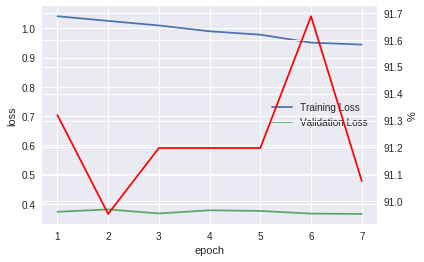

In [17]:
fig, ax1 = plt.subplots()
ax1.plot(range(1, len(train_loss_per_epoch) + 1), train_loss_per_epoch);
ax1.plot(range(1, len(valid_loss_per_epoch) + 1), valid_loss_per_epoch);
plt.legend(['Training Loss', 'Validation Loss']);
plt.xlabel('epoch');
plt.ylabel('loss');

ax2 = ax1.twinx()
ax2.plot(range(1, len(valid_accuracy_per_epoch) + 1), np.asarray(valid_accuracy_per_epoch)*100, color='r');
plt.ylabel('%');
plt.savefig('plot_resnet_152.png')

In [18]:
if IN_COLAB:
    !cp model_augmented.pt 'gdrive/My Drive/pytorch_challenge_models/model_augmented_resnet_152_5.pt'
    !cp plot_resnet_152.png 'gdrive/My Drive/pytorch_challenge_models/plot_resnet_152_5.png'
    print('Model Saved on Drive!')

Model Saved on Drive!


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# Save the checkpoint

# model.class_to_idx = train_datasets.class_to_idx

# torch.save(model, 'model.pth')

# if IN_COLAB:
#     !cp model.pth 'gdrive/My Drive/pytorch_challenge_models/model.pth'

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
if IN_COLAB:
    model = torch.load('gdrive/My Drive/pytorch_challenge_models/model.pth')
else:
    model = torch.load('model.pth')
    
print('Model Loaded!')

_, accuaracy_validation = validation_step(model)
print(f'Model Loaded! Validation Accuracy {accuaracy_validation*100:.2f}%')

Validating Model, Epoch 0:   0%|          | 0/9 [00:00<?, ?it/s]

Model Loaded!


Validating Model, Epoch 0: 100%|██████████| 9/9 [00:27<00:00,  2.55s/it]

Model Loaded! Validation Accuracy 84.96%


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    image.thumbnail((256 if min(image.size) == image.size[0] else image.size[0], 
                     256 if min(image.size) == image.size[1] else image.size[1]))
    
    width, height = image.size   # Get dimensions

    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2

    image = image.crop((left, top, right, bottom))
    
    np_image = np.array(image)/256
    np_image = np.divide(np.subtract(np_image, mean), std)
    
    np_image = np_image.transpose(2, 0, 1)
    return torch.from_numpy(np_image).float()

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    if title:
        ax.set_title(title)
    
    ax.imshow(image)
    
    return ax

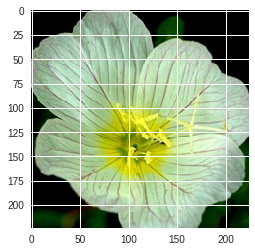

In [0]:
# Test function
im = Image.open("flower_data/valid/1/image_06739.jpg")
imshow(process_image(im));

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    im = Image.open(image_path)
    model.eval()
    model.cpu()
    output = torch.exp(model(process_image(im).unsqueeze(0)))
    probs, classes = output.topk(topk)
    def get_class(index):
        return list(model.class_to_idx.keys())[list(model.class_to_idx.values()).index(index)]
    classes = np.asarray([get_class(c) for c in classes.numpy().ravel()])
    return probs.detach().numpy().ravel(), classes

In [0]:
predict("flower_data/valid/1/image_06739.jpg", model)

(array([0.6937203 , 0.25345305, 0.01048687, 0.00711324, 0.00386687],
       dtype=float32), array(['1', '83', '48', '70', '77'], dtype='<U2'))

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/joaopamaral/pytorch_challenge/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
def view_classify(img_path):
    ''' Function for viewing an image and it's predicted classes.
    '''
    im = Image.open(img_path)

    fig, (ax1, ax2) = plt.subplots(figsize=(9,9), ncols=2)
    
    imshow(process_image(im), ax1, cat_to_name[img_path.split('/')[-2]]);
    ax1.axis('off')
    
    probs, classes = predict(img_path, model)
    
    ax2.barh(np.arange(5), probs)
    ax2.set_aspect(0.2)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels([cat_to_name[c] for c in classes])
    
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    ax2.invert_yaxis()

    plt.tight_layout()

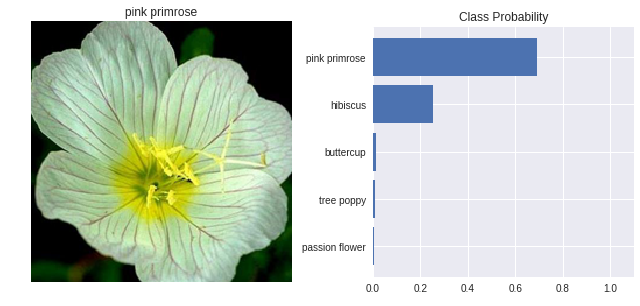

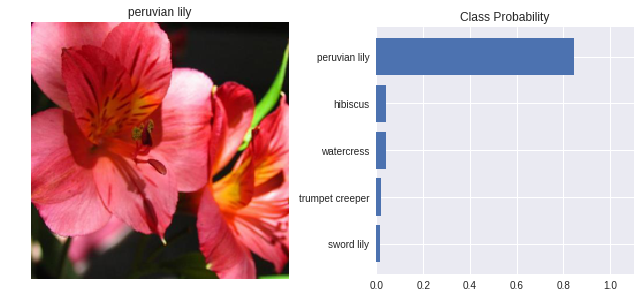

In [0]:
# Display an image along with the top 5 classes
view_classify("flower_data/valid/1/image_06739.jpg")
view_classify("flower_data/valid/18/image_04278.jpg")